In [1]:
import os
from glob import glob

import dask
import numpy as np
import pandas as pd
import xarray as xr

from utils import city_list, gev_metric_ids
import metric_funcs as mf

In [2]:
############
### Dask ###
############
from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers = 10)
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 187.41 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33101,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 187.41 GiB
Comm: tcp://127.0.0.1:38023,Total threads: 1
Dashboard: /proxy/45331/status,Memory: 18.74 GiB
Nanny: tcp://127.0.0.1:38181,


## Calculate metrics 

### Preliminaries

In [3]:
################
#### Paths #####
################
# NOTE: this is run on a different system from other datasets
# Update these for reproduction
from utils import hopper_code_path as project_code_path
from utils import hopper_data_path as project_data_path

tgw_path = "/home/shared/vs498_0001/im3_hyperfacets_tgw/"

In [10]:
ds1 = xr.open_dataset("/home/shared/vs498_0001/im3_hyperfacets_tgw/historical_1980_2019/hourly/tgw_wrf_historical_hourly_1980-01-01_01_00_00.nc")
ds2 = xr.open_dataset("/home/shared/vs498_0001/im3_hyperfacets_tgw/historical_1980_2019/hourly/tgw_wrf_historical_hourly_1980-01-08_01_00_00.nc")

In [20]:
ds2['T2'].max(dim="Time")

<xarray.DataArray 'T2' (south_north: 299, west_east: 424)> Size: 507kB
array([[295.2801 , 295.272  , 295.25613, ..., 300.3043 , 300.37958,
        298.851  ],
       [295.29337, 295.381  , 295.40036, ..., 298.93454, 301.23145,
        298.8214 ],
       [295.32556, 295.42227, 295.46863, ..., 298.9831 , 301.3073 ,
        298.76608],
       ...,
       [280.15128, 280.1745 , 280.11877, ..., 274.17615, 273.989  ,
        274.0716 ],
       [280.07382, 280.07544, 280.01468, ..., 274.19833, 274.22675,
        273.99634],
       [279.99008, 280.06577, 280.4868 , ..., 274.1287 , 274.1026 ,
        274.07086]], dtype=float32)
Dimensions without coordinates: south_north, west_east

In [ ]:
ds

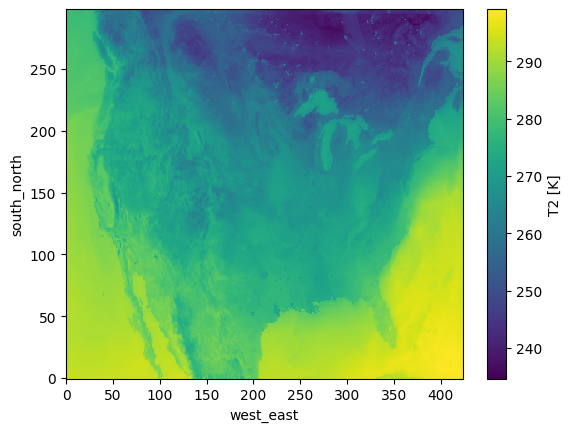

In [8]:
ds['T2'].sel(Time=100).plot()

In [5]:
###############################
# Metric calulcation function #
###############################
def calculate_metric(metric_func, var_id, model_member, needed_vars, gard_path, out_path):
    """
    Inputs: selected model, member, variable, and metric to calculate (from GARD-LENS)
    Outputs: calculated (annual) metric
    """
    try:
        # Check if done
        if os.path.isfile(out_path):
            # print(f"{model_member} already done.")
            return None

        # Read
        if model_member.split('_')[0] == 'ecearth3':
            time_range = '1970_2100'
        else:
            time_range = '1950_2100'
            
        # Read
        ds_tmp = xr.merge([xr.open_dataset(f"{gard_path}/{var}/GARDLENS_{model_member}_{var}_{time_range}_CONUS.nc", chunks='auto') for var in needed_vars])
    
        # Calculate metric
        ds_out = metric_func(ds_tmp, var_id)
    
        # Store
        ds_out.to_netcdf(out_path)
        print(f"{model_member}")
            
    # Log if error
    except Exception as e:
        except_path = f"{project_code_path}/scripts/logs"
        with open(f"{except_path}/{model_member}_{var_id}_GARDLENS.txt", "w") as f:
            f.write(str(e))

In [6]:
############
### Dask ###
############
from dask.distributed import LocalCluster
cluster = LocalCluster(n_workers = 10)
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 187.41 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41393,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 187.41 GiB
Comm: tcp://127.0.0.1:35299,Total threads: 1
Dashboard: /proxy/38003/status,Memory: 18.74 GiB
Nanny: tcp://127.0.0.1:34819,


### Calculations

In [8]:
%%time
##############################
# Average temperature
##############################
var_id = 'tas'
metric_func = mf.calculate_avg
needed_vars = ['t_mean']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/avg_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 2.89 ms, sys: 3.89 ms, total: 6.78 ms
Wall time: 20 ms


In [9]:
%%time
##############################
# Maximum temperature
##############################
var_id = 'tasmax'
metric_func = mf.calculate_max
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/max_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 3.19 ms, sys: 3.62 ms, total: 6.81 ms
Wall time: 34.8 ms


In [10]:
%%time
##############################
# Minimum temperature
##############################
var_id = 'tasmin'
metric_func = mf.calculate_min
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/min_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 3.92 ms, sys: 3.9 ms, total: 7.82 ms
Wall time: 20.6 ms


In [11]:
%%time
#################
# Maximum precip
#################
var_id = 'pr'
metric_func = mf.calculate_max
needed_vars = ['pcp']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/max_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 3.1 ms, sys: 7.44 ms, total: 10.5 ms
Wall time: 58.1 ms


In [12]:
%%time
#################
# Sum precip
#################
var_id = 'pr'
metric_func = mf.calculate_sum
needed_vars = ['pcp']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/sum_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 812 μs, sys: 4.66 ms, total: 5.48 ms
Wall time: 17.3 ms


In [13]:
%%time
##############################
# Cooling degree days: max
##############################
var_id = 'cdd'
metric_func = mf.calculate_dd_max
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/max_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 4.11 ms, sys: 5.76 ms, total: 9.86 ms
Wall time: 77 ms


In [14]:
%%time
##############################
# Cooling degree days: sum
##############################
var_id = 'cdd'
metric_func = mf.calculate_dd_sum
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/sum_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 7.87 ms, sys: 3.42 ms, total: 11.3 ms
Wall time: 75.5 ms


In [15]:
%%time
##############################
# Heating degree days: max
##############################
var_id = 'hdd'
metric_func = mf.calculate_dd_max
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/max_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 9.86 ms, sys: 6.98 ms, total: 16.8 ms
Wall time: 135 ms


In [16]:
%%time
##############################
# Heating degree days: sum
##############################
var_id = 'hdd'
metric_func = mf.calculate_dd_sum
needed_vars = ['t_mean', 't_range']

out_path = lambda model_member: f'{project_data_path}/metrics/GARD-LENS/sum_{var_id}_{model_member}_ssp370.nc'

for model_member in models_members:
    # Calculate metric
    calculate_metric(metric_func = metric_func,
                     var_id = var_id,
                     model_member = model_member,
                     needed_vars = needed_vars,
                     gard_path = gard_path,
                     out_path = out_path(model_member))

CPU times: user 2.42 ms, sys: 3.71 ms, total: 6.13 ms
Wall time: 15.6 ms


# OLD

### Preliminaries

In [1]:
# ################
# #### Paths #####
# ################
# # Update these for reproduction
# from utils import roar_code_path as project_code_path
# from utils import roar_data_path as project_data_path
# gard_gcms = ['canesm5', 'cesm2', 'ecearth3']

In [2]:
# # Get all model members
# models_members = [file.split('/')[-1] for file in glob(f"{project_data_path}/metrics/GARD-LENS/max_tasmax_*.nc")]
# models_members = [file.split('_')[2:5] if file.split('_')[2] == 'cesm2' else file.split('_')[2:4] for file in models_members]
# models_members = ['_'.join(model_member) for model_member in models_members]

## Raw

In [3]:
# # Calculates summary indices for GARD-LENS ensemble member
# def get_raw_data(metric_id, model_member, years, lat, lon, out_path, out_str):
#     """
#     """
#     # Check if done:
#     if not os.path.isfile(f"{out_path}/{out_str}.csv"):
        
#         # Read
#         ds = xr.open_dataset(f'{project_data_path}/metrics/GARD-LENS/{metric_id}_{model_member}_ssp370.nc')
        
#         # Location selection first
#         ds_sel = ds.sel(lat=lat, lon=lon, method='nearest')
        
#         # Time slice
#         if years is not None:
#             ds_sel = ds_sel.sel(time=slice(years[0],years[1]))
#         ds_sel['time'] = ds_sel['time'].dt.year
        
#         # Construct dataframe
#         df_out = ds_sel.to_dataframe().reset_index().dropna().drop(columns=["lat", "lon"])
#         df_out["ssp"] = 'ssp370'
#         # Get info
#         model_member_split = model_member.split('_')
#         model = model_member_split[0]
#         member = model_member_split[1] if len(model_member_split) == 2 else '_'.join(model_member_split[1:])
#         df_out["model"] = model
#         df_out["member"] = member
            
#         # Store
#         df_out.to_csv(f"{out_path}/{out_str}.csv", index=False)

In [4]:
# # Calculate for whole ensemble
# def calculate_all_city_years(metric_id):
#     # Save path
#     out_path = f"{project_data_path}/timeseries/original_grids/"    

#     # Loop through all
#     delayed = []

#     for model_member in models_members:
#         for city in city_list:
#             lat, lon = city_list[city]
#             delayed.append(dask.delayed(get_raw_data)(metric_id = metric_id, 
#                                                       model_member=model_member,
#                                                       years = None, 
#                                                       lat=lat, lon=lon,
#                                                       out_path = out_path,
#                                                       out_str = f"{metric_id}_GARD-LENS_{model_member}_ssp370_{city}"))

#     # Compute
#     _ = dask.compute(*delayed)

In [5]:
# %%time
# # Compute and store all
# for metric_id in metric_ids:
#     calculate_all_city_years(metric_id)
#     print(metric_id)

### Regridded

In [6]:
# # Calculates summary indices for GARD-LENS ensemble for given GCM
# def get_raw_data(metric_id, model, years, lat, lon, out_path, out_str):
#     """
#     """
#     # Check if done
#     if not os.path.isfile(f"{out_path}/{out_str}.csv"):
        
#         # Read all
#         ds = xr.open_mfdataset(f"{project_data_path}/metrics_regridded/GARD-LENS/conservative/{metric_id}_{model}_*.nc", chunks='auto')
    
#         # Time slice
#         ds = ds.rename({'year':'time'})
#         ds_sel = ds.sel(time=slice(years[0],years[1]))

#         # Location selection
#         if lon < 0:
#             lon = 360 + lon
#         ds_sel = ds_sel.sel(lat=lat, lon=lon, method='nearest')
    
#         # Construct dataframe
#         df_out = ds_sel.to_dataframe().drop(columns=["lat", "lon"]).reset_index()
#         df_out["ssp"] = 'ssp370'
#         df_out["model"] = model
        
#         # Store
#         df_out.to_csv(f"{out_path}/{out_str}.csv", index=False)

In [7]:
# %%time
# for city in city_list.keys():
#     lat, lon = city_list[city]
#     for years in [[2020,2040], [2050,2070], [2080,2100]]:
#         for metric_id in ['avg_tas', 'sum_pr', 'max_pr']:
#             for model in gard_info.keys():
#                 get_raw_data(metric_id = metric_id, 
#                              model = model,
#                              years=years,
#                              lat=lat, lon=lon,
#                              out_path=f"{project_data_path}/summary_raw",
#                              out_str=f"{city}_GARD-LENS_{model}_ssp370_{years[0]}-{years[1]}_{metric_id}")